# Using optax for optimization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/03_OptaxForOptimizationInJax.ipynb)

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 3

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to build a little network and evaluate the gradient of the cost function using jax, and how to use optax for optimizing the network. We also discuss the jax random number generator!

Please also see the prior notebooks that show the more basic elements of jax:
- NN_CostFunctionGradientFromJax
- MoreJaxTricks

First version by Florian Marquardt 2024. MIT License.

In [66]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
import jax

import optax # for optimization

from matplotlib import pyplot as plt # plotting
%config InlineBackend.figure_format='retina'

## Defining the network and the cost function

In [67]:
# define a simple neural network
# (arbitrary number of layers, but relu activation at each layer)
def network(parameters,x):
  """
  Evaluate network.

  parameters=[[weights1,biases1],[weights2,biases2],...]
  x=input vector
  """
  for weights,biases in parameters:
    # weights has shape (neurons_lower_layer,neurons_upper_layer),
    # biases has shape (neurons_upper_layer,)
    z=jnp.dot(x,weights)+biases
    x=(z>0)*z # relu activation
  return x

In [68]:
# define a cost function (here: quadratic deviation)
def cost(params,x,y_target):
  return jnp.sum( ( network(params,x) - y_target )**2 )

## Compiling and batch processing

In [69]:
# batches: vmap does the trick!
# It produces a new version of any function, but now with
# a batch index (vectorized processing)!

# in_axes says which index is the batch index, for each
# of the arguments of the function. 'params' (the first argument)
# does not have any batch index, therefore we write 'None':
batched_cost=vmap(cost,in_axes=(None,0,0))

In [70]:
# want to average the cost over the batch:
def average_cost(params,x,y_target):
  return jnp.average(batched_cost(params,x,y_target))

In [71]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

## Training using optax

### Function for producing a random batch of training samples

In [132]:
# generating random numbers in jax is special:
# because we want to deal with 'pure' functions, we
# need to explicitly keep track of the state of the
# random number generator, in the form of a 'key'
random_key = jax.random.key(42) # first 'key', like setting a random seed
random_key,new_key = jax.random.split(random_key) # generate additional 'new_key'
# now produce an array of random Gaussian-distributed numbers
# here with a shape (8,3), just as an example:
my_random_numbers = jax.random.normal(new_key,shape=(8,3))
# from here on, you can continue, each time splitting off
# from the key:
random_key,new_key = jax.random.split(random_key)
my_random_numbers_2 = jax.random.normal(new_key,shape=(5,2))
# and so on...


In [133]:
# produce training batches where the input is
# random 2D coordinates and the output is the corresponding
# value of a function that we want to fit

def myFunc(x):
    r2=x[:,0]**2+x[:,1]**2
    batch_size=jnp.shape(x)[0]
    return jnp.reshape(jnp.exp(-10*r2), (batch_size,1)) # to get proper shape

def make_batch(batch_size,key):
    inputs=jax.random.uniform(key,minval=-0.5,maxval=+0.5,shape=(batch_size,2))
    targets=myFunc(inputs)
    return inputs,targets



### Random preparation of network parameters

In [162]:
# get an initial random key for the random number generator to
# produce random batches during training loop (see below)
random_key = jax.random.key(47)

# our network has structure 2 (input) -- 50 -- 1 (output)
# get randomly initialized weights and biases
# use jax random number generator
# first get several different random keys:
n_hidden=200
random_key,key1,key2,key3,key4=jax.random.split(random_key,5)
weights1=jax.random.normal(key1,shape=(2,n_hidden))/jnp.sqrt(n_hidden)
biases1=jax.random.normal(key2,shape=(n_hidden,))
weights2=jax.random.normal(key1,shape=(n_hidden,1))/jnp.sqrt(n_hidden)
biases2=jax.random.normal(key2,shape=(1,))

# initial values of parameters
params=[[weights1,biases1],[weights2,biases2]]

### Preparation of the optax 'optimizer'

In [163]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

### Running the training loop

In [164]:
# now you can run a training loop:
num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  x,y = make_batch(batch_size,new_key)

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

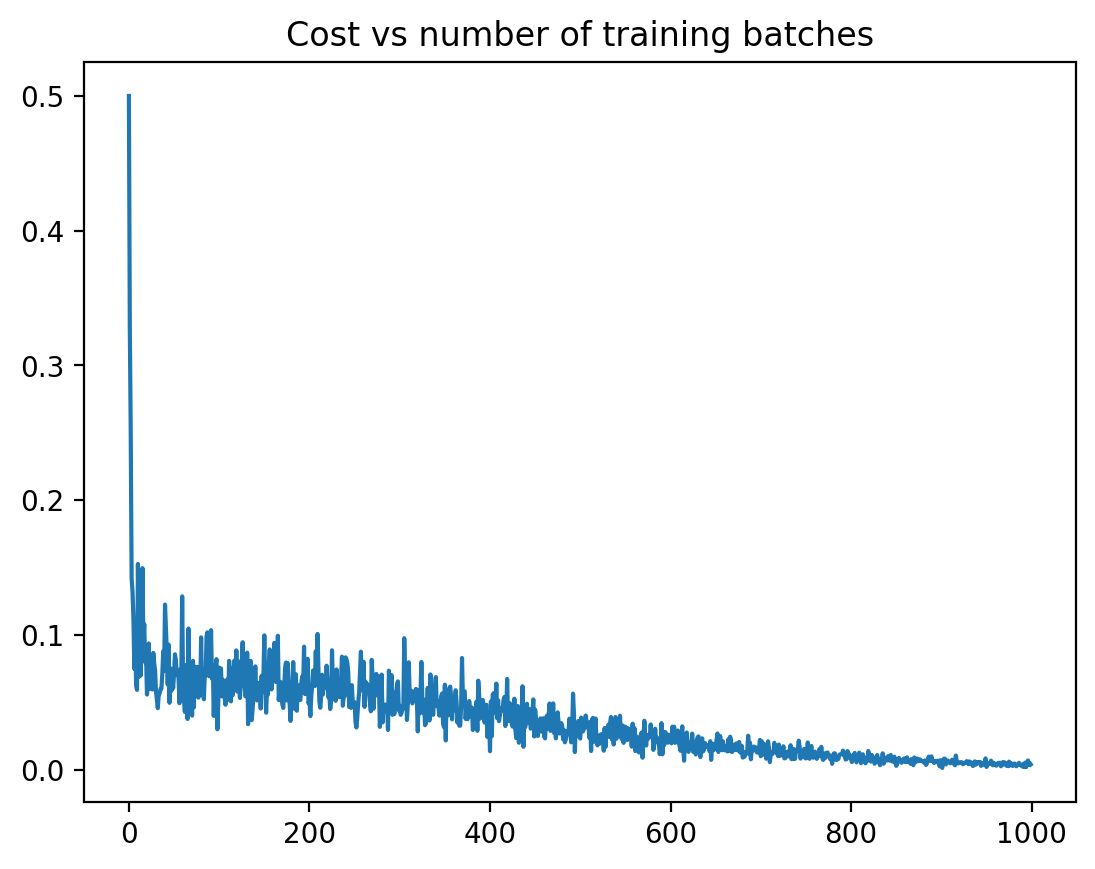

In [165]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

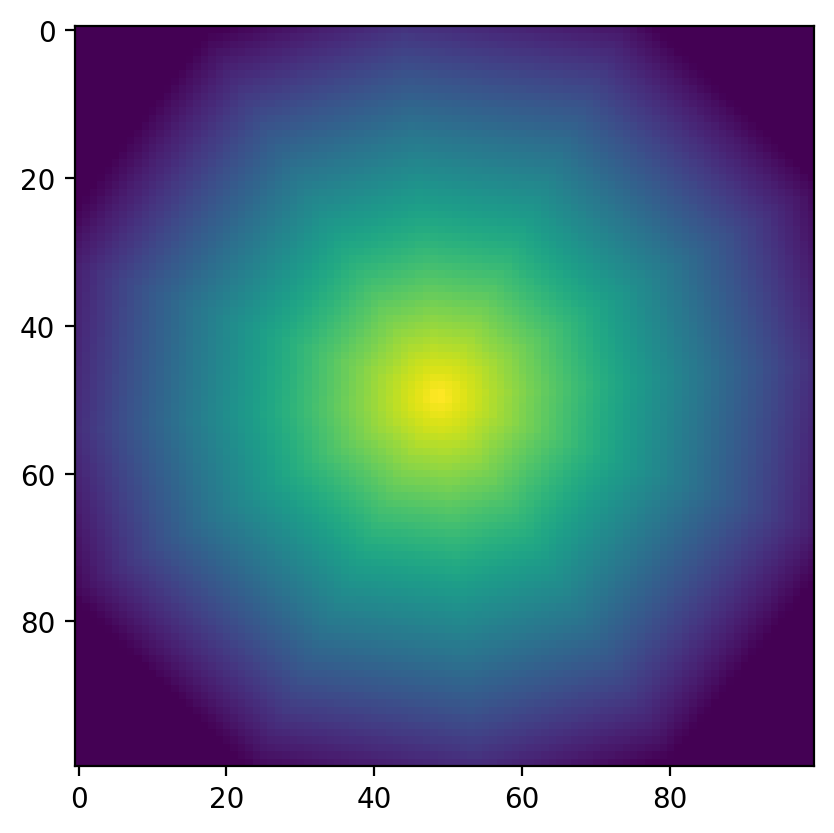

In [166]:
n_pixels=100
values=jnp.linspace(-0.5,0.5,n_pixels)
x0,x1=jnp.meshgrid(values,values)
x=jnp.stack([x0,x1],axis=-1)

result=network(params,x) # shape (n_pixels,n_pixels,1)

plt.imshow(result[:,:,0])
plt.show()